# Routine to read in available sounding data and interpolate to regular height interval (single year)


https://weather.uwyo.edu/upperair/sounding.html

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 12})
import xarray as xr
import pandas as pd
from datetime import datetime
from datetime import timedelta

# meteorology - specific
from metpy.calc import relative_humidity_from_dewpoint
from metpy.units import units
from siphon.simplewebservice.wyoming import WyomingUpperAir

import sys
sys.path.append('./scripts/')

from LIB_dates import generate_date_list
from LIB_request_WUA_sounding import check_for_WUA_soundings
from LIB_sounding_analysis import interpolate_soundings
from LIB_sounding_date_checks import grab_sounding_dates

### Specify parameters to retreive sounding data

season should be either 'winter', 'spring', 'summer', 'autumn', or 'all' for all year

In [2]:
# specify year, season, sounding hours
# specify site and height range
#===============================
year = 1998
season = 'spring'
hours = [0]

station = 'PABR'

max_height = 6*units.kilometer
min_height =  0*units.kilometer
bin_width = 0.1*units.kilometer
#===============================

# julian day ranges for each season
season_bounds = {}
season_bounds['winter'] = {'start': 0,   'end': 91}
season_bounds['spring'] = {'start': 91,  'end': 182}
season_bounds['summer'] = {'start': 182, 'end': 274}
season_bounds['autumn'] = {'start': 274, 'end': 366}

# find all julian days (/hours) with soundings for given year
doy, sou, year = grab_sounding_dates(csv=f'./sounding_checks/checked_{year}0101Z00_{year}1231Z23_hourly6.csv', hours=hours)
days_with_soundings = doy[sou==1]

# crop days to specified season
if str(season) == 'all':
    doy_soundings = days_with_soundings
else:
    doy_soundings = days_with_soundings[(days_with_soundings>(season_bounds[season]['start']))&
                                          (days_with_soundings<=(season_bounds[season]['end']))]


### Retrieve and interpolate data

In [3]:
all_RH = np.array([])
all_T = np.array([])
all_dates = np.array([])
all_doy = np.array([])

for ii in range(len(doy_soundings)):
    
    # create date
    doy = int(doy_soundings[ii]) # round down to julian day
    hour = int(24*(doy_soundings[ii]%1)) # grab hours
    date = datetime.strptime(f'{year}-{doy}-{hour}', '%Y-%j-%H')
    
    print(date)
    
    # request data using siphon
    # try request multiple times in case there is error with first
    num_tries = 5
    for attempt in range(num_tries):
        try:
            df = WyomingUpperAir.request_data(date, station)
            worked = True
        except:
            worked = False
        if worked == True:
            break
    if worked == False:
        df = []
        print(f"No data available for {date}")
            
    # if data request was succesful:
    # pull out T, Td, H and calculate RH
    #-----------------------------------
    if len(df) > 0:

        # assign units to all data
        height = df['height'].values * units(df.units['height']).to(units.kilometer)
        temperature = df['temperature'].values * units(df.units['temperature'])
        dewpoint = df['dewpoint'].values * units(df.units['dewpoint'])

        # crop all to below 10 km
        H = height[height < 10*units.kilometer]
        T = temperature[height < 10*units.kilometer]
        Td = dewpoint[height < 10*units.kilometer]

        # calculate relative humidity
        RH = relative_humidity_from_dewpoint(T, Td).to('percent')

    # interpolate 
    #-----------------------------------  

    try:
        [new_RH, new_T], new_H, edges = interpolate_soundings(variable = [RH, T], heights = H, 
                                                              bin_width = bin_width, min_height = min_height, 
                                                              max_height = max_height, method = 'mean', 
                                                              suppress_plots = True, suppress_prints = True)
        all_RH = np.append(all_RH, new_RH)
        all_T = np.append(all_T, new_T)
        all_dates = np.append(all_dates, date)
        all_doy = np.append(all_doy, doy_soundings[ii])
    
    except:
        print(f'  - issue with retrieval on {date}')
        
# reshape to dimensions: date, height
RH = np.reshape(all_RH, (int(len(all_RH)/len(new_H)), len(new_H)))
T = np.reshape(all_T, (int(len(all_T)/len(new_H)), len(new_H)))

# create grids to plot with pcolormesh
H, dates = np.meshgrid(new_H.magnitude, all_dates)
H, DOY = np.meshgrid(new_H.magnitude, all_doy)

1998-04-02 00:00:00
1998-04-03 00:00:00
1998-04-04 00:00:00
1998-04-05 00:00:00
1998-04-06 00:00:00
1998-04-07 00:00:00
1998-04-08 00:00:00
1998-04-09 00:00:00
1998-04-10 00:00:00
1998-04-11 00:00:00
1998-04-12 00:00:00
1998-04-13 00:00:00
1998-04-14 00:00:00
1998-04-15 00:00:00
1998-04-16 00:00:00
1998-04-19 00:00:00
1998-04-20 00:00:00
1998-04-21 00:00:00
1998-04-22 00:00:00
1998-04-23 00:00:00
1998-04-24 00:00:00
1998-04-25 00:00:00
1998-04-26 00:00:00
1998-04-27 00:00:00
1998-04-28 00:00:00
1998-04-29 00:00:00
1998-04-30 00:00:00
1998-05-01 00:00:00
1998-05-02 00:00:00
1998-05-03 00:00:00
1998-05-04 00:00:00
1998-05-05 00:00:00
1998-05-06 00:00:00
1998-05-07 00:00:00
1998-05-08 00:00:00
1998-05-09 00:00:00
1998-05-10 00:00:00
1998-05-11 00:00:00
1998-05-13 00:00:00
1998-05-14 00:00:00
1998-05-15 00:00:00
1998-05-16 00:00:00
1998-05-17 00:00:00
1998-05-19 00:00:00
1998-05-20 00:00:00
1998-05-21 00:00:00
1998-05-22 00:00:00
1998-05-23 00:00:00
1998-05-24 00:00:00
1998-05-25 00:00:00


### plot seasonal relative humidity and temperatures

Text(0.5, 0, 'day of year')

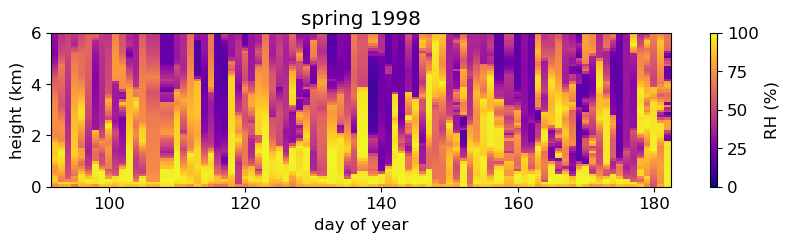

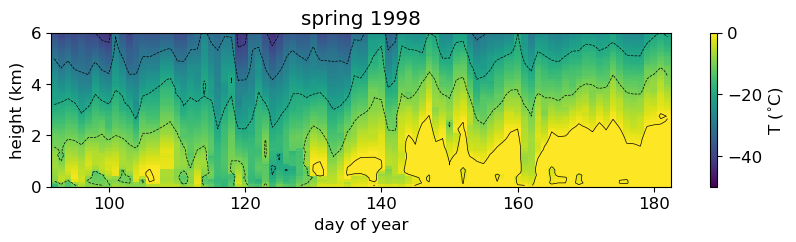

In [5]:

fig, ax = plt.subplots(figsize=(10,2))
rh = ax.pcolormesh(DOY, H, RH, vmin=0, vmax=100, cmap='plasma')
plt.colorbar(rh, label='RH (%)')
ax.set_title(f'{season} {year}')
ax.set_ylabel('height (km)')
ax.set_xlabel('day of year')


fig, ax = plt.subplots(figsize=(10,2))
t = ax.pcolormesh(DOY, H, T, vmin=-50, vmax=0)
ax.contour(DOY, H, T, colors='k', linewidths=0.5, levels=[-50,-40,-30,-20,-10,0], vmin=-50, vmax=0)
plt.colorbar(t, label='T ($^{\circ}$C)')
ax.set_title(f'{season} {year}')
ax.set_ylabel('height (km)')
ax.set_xlabel('day of year')

### Plot frequency of RH threshold passed seasonall as a function of height

Text(0.5, 0, 'frequency (%)')

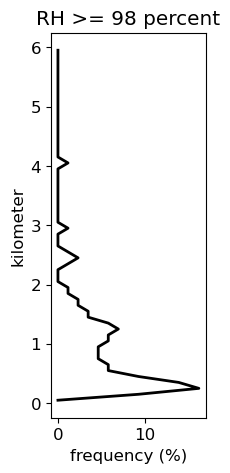

In [11]:
#===========================
rh_thresh = 98*units.percent
#===========================

rh_freq = 100*np.sum(RH>=rh_thresh, axis=0)/RH.shape[0]

fig, ax = plt.subplots(figsize=(2,5))
ax.plot(rh_freq, new_H, color='k', lw = 2, label='winter')
ax.set_title(f'RH >= {rh_thresh}')
ax.set_xlabel('frequency (%)')

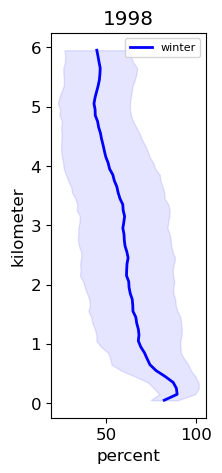

In [13]:

def plot_var_spread(ax, var, color='red', label = 'winter'):
    ax.plot(np.mean(var, axis=0), new_H, color=COLOR, lw = 2, label=label)
#     ax.plot(np.mean(var.magnitude, axis=0)-np.std(var.magnitude, axis=0), new_H, color=COLOR, lw = 0.5)
#     ax.plot(np.mean(var.magnitude, axis=0)+np.std(var.magnitude, axis=0), new_H, color=COLOR, lw = 0.5)
    ax.fill_betweenx(new_H,np.mean(var.magnitude, axis=0)-np.std(var.magnitude, axis=0), np.mean(var.magnitude, axis=0)+np.std(var.magnitude, axis=0),
                    alpha=0.1, zorder=-1, color=COLOR)
    
    
    
fig, ax = plt.subplots(figsize=(2,5))

#==========
VAR = RH
#==========

COLOR = 'blue'
var = VAR
plot_var_spread(ax, var, color=COLOR, label = 'winter')

# COLOR = 'dodgerblue'
# var = VAR[np.where(all_doy==90)[0][0]:np.where(all_doy==182)[0][0], :]
# plot_var_spread(ax, var, color=COLOR, label = 'spring')

# COLOR = 'indianred'
# var = VAR[np.where(all_doy==182)[0][0]:np.where(all_doy==274)[0][0], :]
# plot_var_spread(ax, var, color=COLOR, label = 'summer')

# COLOR = 'darkorange'
# var = VAR[np.where(all_doy==274)[0][0]:, :]
# plot_var_spread(ax, var, color=COLOR, label = 'autumn')


ax.set_title(f'{year}')
plt.legend(fontsize=8)
